In [20]:
from pydub import AudioSegment
import os
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
import noisereduce as nr
import numpy as np
import torchaudio
import torch
from silero_vad import (load_silero_vad,
                          read_audio,
                          get_speech_timestamps,
                          save_audio,
                          VADIterator,
                          collect_chunks)

from pedalboard.io import AudioFile
from pedalboard import *
from IPython.display import Audio
from pydub import AudioSegment, effects
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


## Prepare and Clean Data

In [2]:
base_folder = './VoxCeleb_gender'
male_folder = os.path.join(base_folder, 'males')
female_folder = os.path.join(base_folder, 'females')

# Create directories to store the converted wav files
output_male_folder = os.path.join(base_folder, 'males_wav')
output_female_folder = os.path.join(base_folder, 'females_wav')

# os.makedirs(output_male_folder, exist_ok=True)
# os.makedirs(output_female_folder, exist_ok=True)

In [3]:
# # Function to convert m4a to wav
# def convert_m4a_to_wav(input_folder, output_folder):
#     for file_name in os.listdir(input_folder):
#         if file_name.endswith('.m4a'):
#             file_path = os.path.join(input_folder, file_name)
#             output_path = os.path.join(output_folder, file_name.replace('.m4a', '.wav'))
#             # Convert to wav
#             audio = AudioSegment.from_file(file_path, format='m4a')
#             audio.export(output_path, format='wav')
#             print(f"Converted: {file_name} to {output_path}")

In [4]:
# # Convert male and female folders
# convert_m4a_to_wav(male_folder, output_male_folder)
# convert_m4a_to_wav(female_folder, output_female_folder)

In [5]:
# # Initialize a list to hold the data
# data = []

# # Function to add file paths, metadata, and audio data to the list
# def add_to_dataframe(folder_path, gender_label):
#     for file_name in os.listdir(folder_path):
#         # print(file_name)
#         if file_name.endswith('.wav'):
#             # print(1)
#             file_path = os.path.join(folder_path, file_name)
#             # print(file_path)
#             # print(1)
#             # Load the file to calculate the duration and get the audio data
#             y, sr = librosa.load(file_path, sr=None)
#             # print(1)
#             duration = librosa.get_duration(y=y, sr=sr)
#             # print(1)
#             # Append the data including the raw audio data (waveform)
#             data.append({
#                 'File_Path': file_path,
#                 'Gender_Label': gender_label,
#                 'Duration': duration,
#                 'Audio_Data': y,  # Add audio data (waveform)
#                 'Sample_Rate': sr  # Add sample rate (for future use if needed)
#             })
#             print(len(data))

# # Process the wav files from the male and female folders
# add_to_dataframe(output_male_folder, 'male')
# add_to_dataframe(output_female_folder, 'female')

In [6]:
# # Create the DataFrame
# df = pd.DataFrame(data)

In [7]:
# # Save the DataFrame to a CSV file
# df.to_csv('/content/drive/MyDrive/VoxCeleb_gender/audio_metadata.csv', index=False)

# # Save the DataFrame as a Pickle file
# df.to_pickle('/content/drive/MyDrive/VoxCeleb_gender/audio_metadata.pkl')


In [ ]:
# duration_stats = df['Duration'].describe()

# print("Summary Statistics for Audio Duration:")
# print(duration_stats)

In [ ]:


# # Plotting a histogram of the durations
# plt.figure(figsize=(10, 6))
# plt.hist(df['Duration'], bins=20, edgecolor='black')
# plt.title('Distribution of Audio Durations')
# plt.xlabel('Duration (seconds)')
# plt.ylabel('Frequency')
# plt.show()

# # Plotting a boxplot to identify outliers
# plt.figure(figsize=(10, 6))
# plt.boxplot(df['Duration'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
# plt.title('Boxplot of Audio Durations')
# plt.xlabel('Duration (seconds)')
# plt.show()

In [8]:
# df_filtered = df[df['Duration'] <= 13]

# # Display the shape of the filtered DataFrame
# print(f"Original number of audio files: {df.shape[0]}")
# print(f"Number of audio files after removing outliers: {df_filtered.shape[0]}")

### Summary:
In this section, audio data from the `VoxCeleb_gender` dataset is prepared and cleaned. Specifically:

- Directories are set up for storing male and female audio files.
- A function is defined to convert `.m4a` audio files into `.wav` format, although it is currently commented out.
- Another function is implemented to load each `.wav` file, extract its metadata (such as the file path, gender label, audio duration, and sample rate), and store this information in a list.
- The list of audio metadata is then converted into a Pandas DataFrame, which is saved as both a CSV and a Pickle file for future use.
- Finally, audio durations are analyzed using statistical summaries and visualized using histograms and boxplots to inspect the distribution and identify potential outliers. Files with durations longer than 13 seconds are filtered out.


## Preprecoess Audio

In [13]:
# List to store noise-reduced audio data
noise_reduced_audio_list = []

# Apply pedalboard effects
board = Pedalboard([
        NoiseGate(threshold_db=-3, ratio=2, release_ms=300),  # Softer gating to avoid cutting off quieter parts
        Compressor(threshold_db=-6, ratio=2),  # Lower compression ratio for smoother voice
        LowShelfFilter(cutoff_frequency_hz=10, gain_db=3),  # Reduced low-end boost to avoid excessive rumble
        Gain(gain_db=3)  # Softer gain to avoid over-amplification
    ])

# Loop through each row in df_filtered and apply noise reduction
for index, row in df_filtered.iterrows():
    sample_audio_data = row['Audio_Data']
    sample_sr = row['Sample_Rate']

    S_full, phase = librosa.magphase(librosa.stft(sample_audio_data)) # compute the spectrogram magnitude and phase

    S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(0.5, sr=sample_sr)))
    S_filter = np.minimum(S_full, S_filter) 

    margin_i, margin_v = 10, 1 
    power = 2

    mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
    mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full

    noise_reduced_audio = librosa.istft(S_foreground * phase)

    noise_reduced_audio = (noise_reduced_audio * 32767).astype(np.int16)
    noise_reduced_audio = AudioSegment(
        noise_reduced_audio.tobytes(),  # Convert to byte data
        frame_rate=sample_sr,  # Sample rate
        sample_width=2,  # Number of bytes per sample (16-bit audio)
        channels=1  # Mono audio
    )

    noise_reduced_audio = effects.normalize(noise_reduced_audio, headroom=2)  
    noise_reduced_audio = np.array(noise_reduced_audio.get_array_of_samples()).astype(np.float32) / 32767

    noise_reduced_audio_list.append(noise_reduced_audio)

    print(len(noise_reduced_audio_list))

# Add the noise-reduced audio data as a new column in the DataFrame
df_filtered['audio_noisereduced'] = noise_reduced_audio_list

# Save or display the updated DataFrame
print("Noise reduction applied and new column added successfully.")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### Summary:
In this section, audio preprocessing is performed, specifically focusing on noise reduction and applying audio effects to the filtered dataset (`df_filtered`). The following steps were carried out:

- **List Initialization**: A list (`noise_reduced_audio_list`) is initialized to store noise-reduced versions of the audio files.
  
- **Audio Effects with Pedalboard**: A chain of effects is defined using the `Pedalboard` library:
  - **NoiseGate**: Soft gating is applied to reduce noise but without cutting off quieter parts of the audio.
  - **Compressor**: Compression with a lower threshold and ratio is applied to smooth out the dynamic range of the audio.
  - **LowShelfFilter**: A filter is applied to reduce excessive low-frequency rumble while slightly boosting low-end frequencies.
  - **Gain**: Soft gain is applied to ensure the audio isn't overly amplified.

- **Noise Reduction Process**: 
  - For each audio file in the filtered DataFrame, the following steps are performed:
    - The spectrogram magnitude and phase are computed using `librosa.stft` and `librosa.magphase`, which decomposes the audio into frequency components.
    - **Spectrogram Filtering**: The spectrogram is filtered using `librosa.decompose.nn_filter`, where the median of neighboring frames is used to reduce background noise.
    - **Softmasking**: Masks are computed to separate the foreground (speech) and background (noise) using `librosa.util.softmask`. The parameters (`margin_i`, `margin_v`, and `power`) control the balance between isolating the foreground and reducing the background.
    - **Inverse STFT**: The foreground spectrogram is then converted back into a time-domain signal using the inverse Short-Time Fourier Transform (`librosa.istft`).

- **Normalization**: 
  - The noise-reduced audio is normalized using `pydub.effects.normalize` to ensure consistent loudness across the audio files, while maintaining a headroom of 2 dB to prevent clipping.

This preprocessing step is crucial as it ensures that the audio files used for subsequent analysis are cleaner and more uniform, improving the performance of any downstream tasks like gender classification.


## Apply VAD

In [16]:
# Load the Silero VAD model
vad_model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                                model='silero_vad',
                                force_reload=True,
                                onnx=False)
(get_speech_timestamps,
  save_audio,
  read_audio,
  VADIterator,
  collect_chunks) = utils


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/ahmed.aboeitta/.cache/torch/hub/master.zip


In [17]:
# List to store the results of 'contain_speech'
contain_speech_list = []

# Loop through the entire DataFrame
for index, row in df_filtered.iterrows():
    sample_audio_data = row['audio_noisereduced']
    sample_sr = row['Sample_Rate']

    # Convert audio data to the format expected by the VAD model
    audio_tensor = torch.tensor(sample_audio_data).float()
    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)  # Add batch dimension if necessary

    # Get speech timestamps
    speech_timestamps = get_speech_timestamps(audio_tensor, vad_model, sampling_rate=sample_sr)

    # Determine the speech status
    if len(speech_timestamps) == 0:
        contain_speech_list.append(0)  # No speech detected
    else:
        contain_speech_list.append(1)  # More than one speech segment detected

# Add the new column 'contain_speech' to the DataFrame
df_filtered['contain_speech'] = contain_speech_list

# Save or further process the updated DataFrame
print("Speech detection applied, and 'contain_speech' column added.")

Speech detection applied, and 'contain_speech' column added.


In [18]:
df_filtered['contain_speech'].value_counts()

contain_speech
1    5585
0       2
Name: count, dtype: int64

In [19]:
df_filtered[df_filtered['contain_speech'] == 0]

,File_Path,Gender_Label,Duration,Audio_Data,Sample_Rate,audio_noisereduced,contain_speech,embeddings,whisper_tiny_embeddings,whisper_base_embeddings,gender_label,whisper_small_embeddings
4868,./VoxCeleb_gender/females_wav/407.wav,female,4.032,"[0.036102295, 0.03933716, 0.046173096, 0.04742...",16000,"[0.09540086, 0.10864589, 0.13180944, 0.1331217...",0,"[-0.031005241, 0.20889269, 0.0019192058, -0.01...","[-0.15761818, -0.55180544, 0.87246454, -0.3002...","[-0.09495097, -0.40349507, 0.23783384, -0.8885...",1,"[-0.056800198, -0.03140875, 0.568562, 0.055953..."
5890,./VoxCeleb_gender/females_wav/1625.wav,female,4.864,"[-0.04763794, 0.03930664, 0.13891602, 0.313476...",16000,"[-0.032044437, 0.022797327, 0.097598195, 0.184...",0,"[-0.031178415, 0.20953575, 0.0025200734, -0.01...","[-0.15766905, -0.5755752, 0.80322784, -0.45017...","[0.1768468, -0.0744106, 0.104476035, -0.859748...",1,"[0.1718406, 0.016771933, 0.5832863, -0.1038893..."


### Summary:
In this section, a Voice Activity Detection (VAD) model is applied to the noise-reduced audio data to detect whether speech is present. The steps include:

- The Silero VAD model is loaded using `torch.hub.load`.
- Each audio file in the DataFrame is processed by converting the noise-reduced audio data into the format expected by the VAD model (a tensor).
- The model is used to detect speech timestamps, and based on the results, a new column `contain_speech` is added to the DataFrame:
  - `0` indicates no speech was detected.
  - `1` indicates speech was detected.
- The updated DataFrame is saved with the new column showing the speech detection results.

This step ensures that only files containing speech are processed further.


## Testing Pipeline

In [21]:
df_filtered = pd.read_pickle('./VoxCeleb_gender/audio_metadata.pkl')

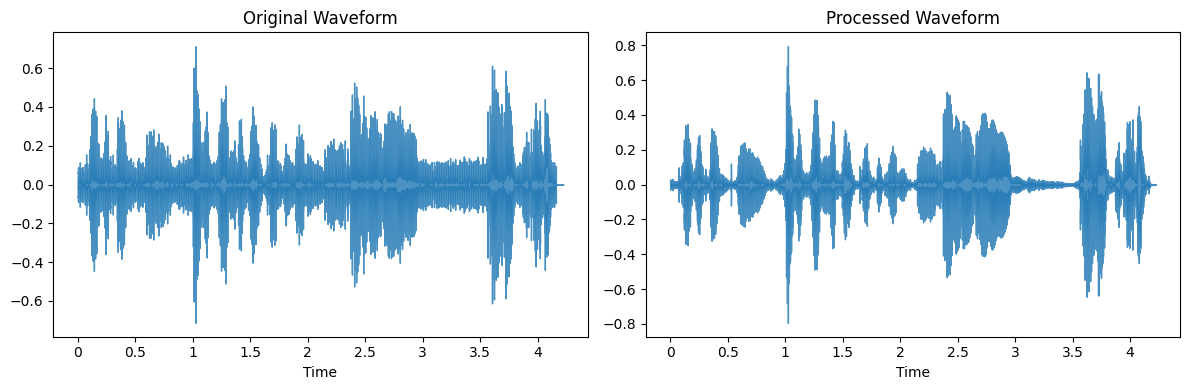

Original Audio:


Processed Audio:


Contains speech: True
Contains speech: [{'start': 0, 'end': 53728}, {'start': 56352, 'end': 67584}]


In [33]:
import matplotlib.pyplot as plt

def process_audio_file(audio_data, sample_rate):
    
    S_full, phase = librosa.magphase(librosa.stft(audio_data)) 

    S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(0.2, sr=sample_rate)))
    S_filter = np.minimum(S_full, S_filter) 

    margin_i, margin_v = 10, 1
    power = 3

    mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
    mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full

    noise_reduced_audio = librosa.istft(S_foreground * phase)

    noise_reduced_audio = (noise_reduced_audio * 32767).astype(np.int16)
    noise_reduced_audio = AudioSegment(
        noise_reduced_audio.tobytes(),  
        frame_rate=sample_rate,  
        sample_width=2,  
        channels=1  
    )

    noise_reduced_audio = effects.normalize(noise_reduced_audio, headroom=2)
    noise_reduced_audio = np.array(noise_reduced_audio.get_array_of_samples()).astype(np.float32) / 32767
    audio_tensor = torch.tensor(noise_reduced_audio).float()
    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)  # Add batch dimension if necessary
    speech_timestamps = get_speech_timestamps(audio_tensor, vad_model, sampling_rate=sample_rate)

    # Determine if speech is detected
    contains_speech = len(speech_timestamps) > 0

    # Plot the waveforms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.8)
    plt.title('Original Waveform')

    plt.subplot(1, 2, 2)
    librosa.display.waveshow(noise_reduced_audio, sr=sample_rate, alpha=0.8)
    plt.title('Processed Waveform')

    plt.tight_layout()
    plt.show()

    return noise_reduced_audio, contains_speech, speech_timestamps


# Example usage:
index_to_listen = 512
audio_data = df_filtered.loc[index_to_listen, 'Audio_Data']
sample_rate = df_filtered.loc[index_to_listen, 'Sample_Rate']

processed_audio, contains_speech, speech_timestamps = process_audio_file(audio_data, sample_rate)

print("Original Audio:")
display(Audio(audio_data, rate=sample_rate))

print("Processed Audio:")
display(Audio(processed_audio, rate=sample_rate))

print(f"Contains speech: {contains_speech}")

print(f"Contains speech: {speech_timestamps}")

/tmp/slurm-ahmed.aboeitta-40623/ipykernel_3723148/782316368.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title


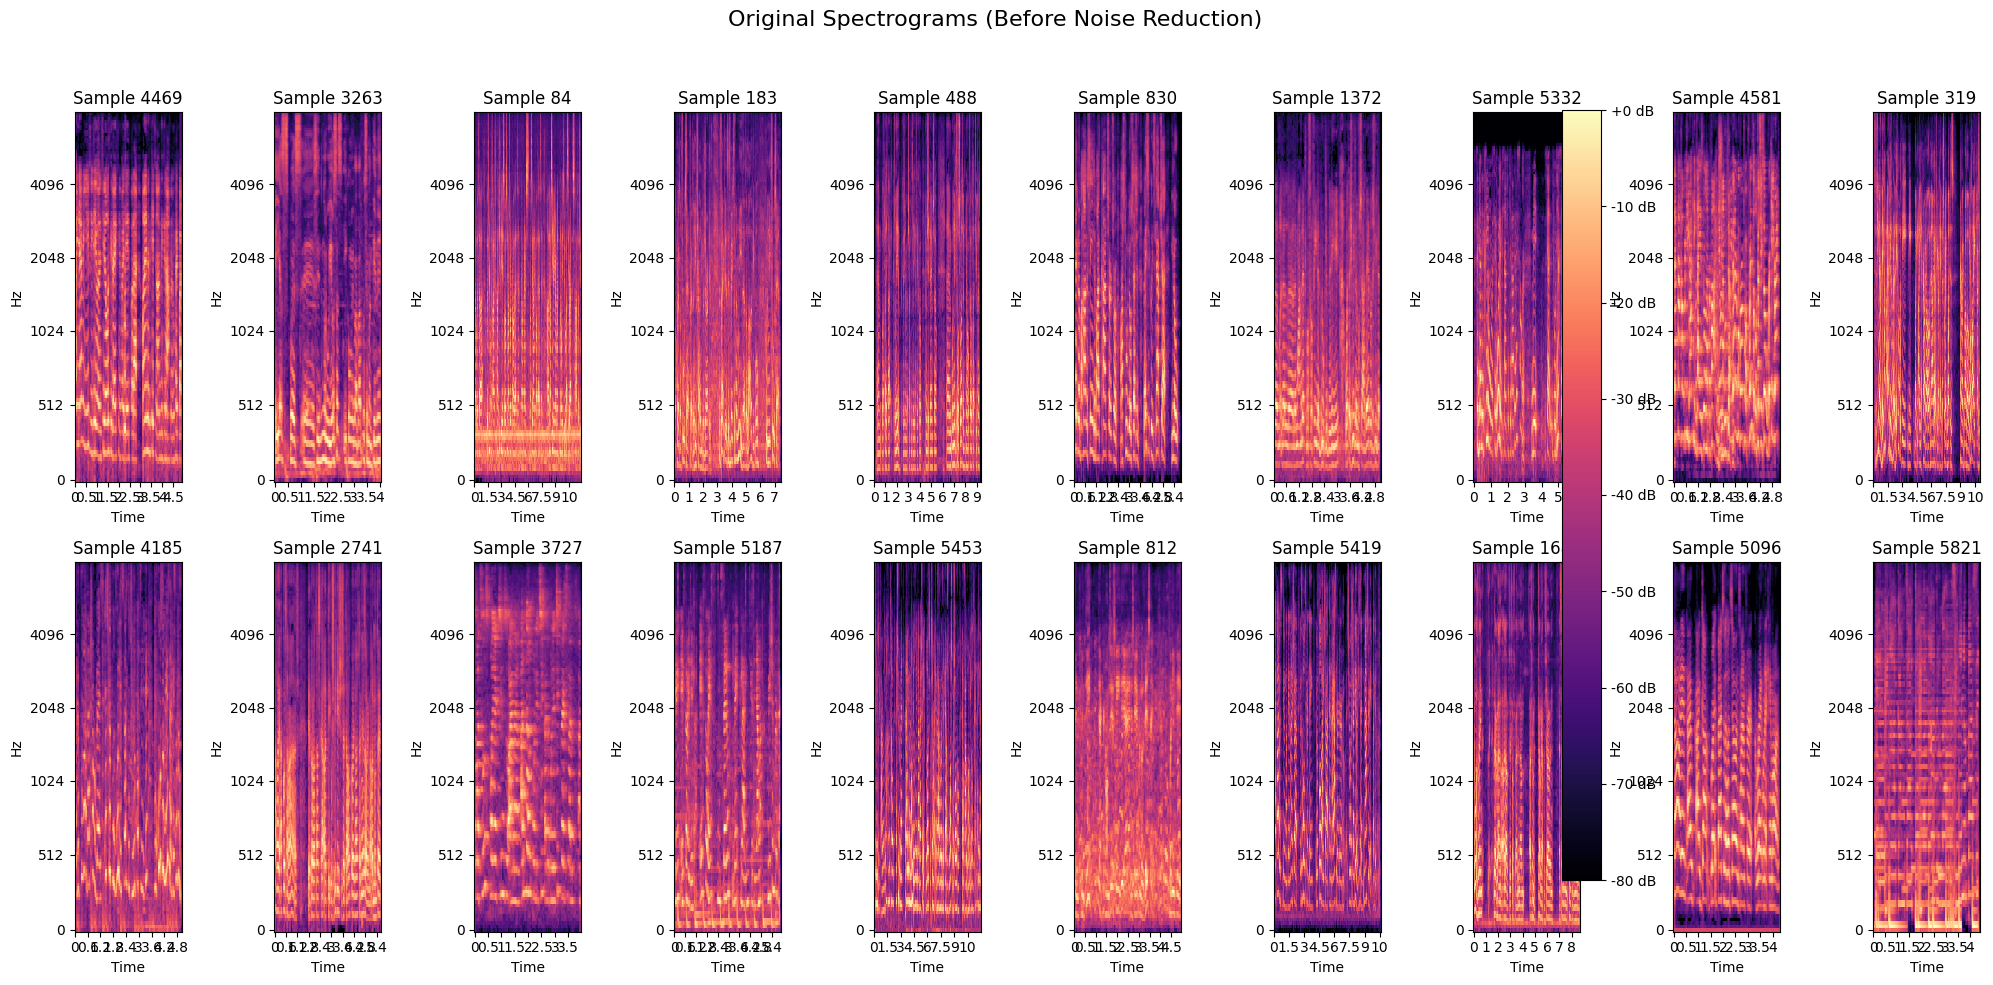

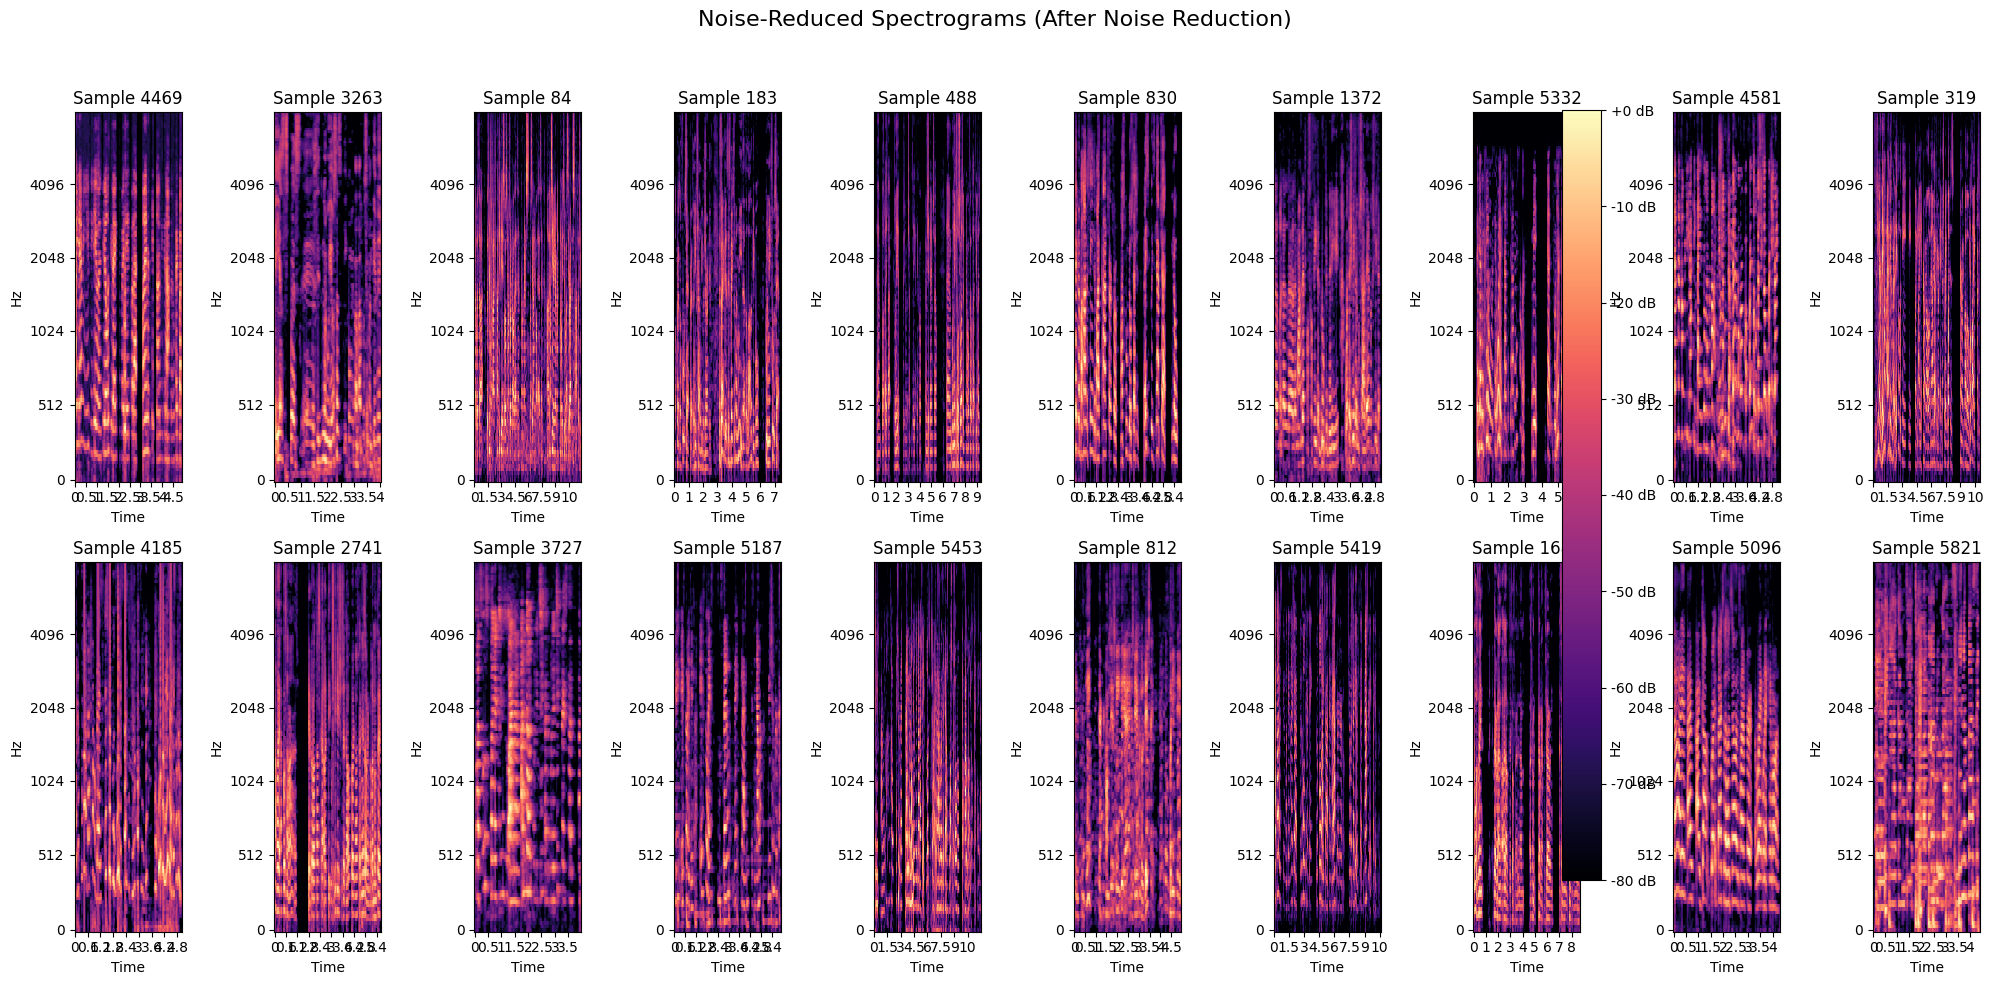

In [35]:
# Function to plot spectrograms in subplots
def plot_spectrogram_grid(audio_data_list, sr_list, titles, grid_title, rows=2, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    fig.suptitle(grid_title, fontsize=16)

    for i, (audio_data, sr, title) in enumerate(zip(audio_data_list, sr_list, titles)):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, sr=sr, ax=ax, x_axis='time', y_axis='mel', fmax=8000)
        ax.set_title(title)

    fig.colorbar(img, ax=axes, format="%+2.f dB")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()
    
    
random_samples = df_filtered.sample(n=20, random_state=42)

original_audio_list = []
reduced_audio_list = []
sr_list = []
titles = []

# Loop through the random audio samples
for index, row in random_samples.iterrows():
    sample_audio_data = row['Audio_Data']
    sample_sr = row['Sample_Rate']

    # Append original audio data
    original_audio_list.append(sample_audio_data)
    sr_list.append(sample_sr)
    titles.append(f"Sample {index}")

    reduced_audio_data = row['audio_noisereduced']


    # Append noise-reduced audio data
    reduced_audio_list.append(reduced_audio_data)

# Plot original spectrograms (before noise reduction)
plot_spectrogram_grid(original_audio_list, sr_list, titles, grid_title="Original Spectrograms (Before filteration)")

# Plot noise-reduced spectrograms (after noise reduction)
plot_spectrogram_grid(reduced_audio_list, sr_list, titles, grid_title="Noise-Reduced Spectrograms (After after filteration)")

### Summary:
In this section, we are testing the effectiveness of the audio processing pipeline and debug its performance. 
The goal of this section is to evaluate how well the noise reduction and speech detection components perform in real-world audio data, allowing for debugging and tuning of the pipeline if necessary. This helps ensure the robustness of the pipeline before further use or deployment.


## Get Audio Embeddings

In [17]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Load Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53")

# List to store the embeddings
embeddings_list = []

# Loop through the entire DataFrame and extract embeddings
for index, row in df_filtered.iterrows():
    sample_audio_data = row['audio_noisereduced']
    sample_sr = row['Sample_Rate']

    # Preprocess the audio data
    input_values = processor(sample_audio_data, return_tensors="pt", sampling_rate=sample_sr).input_values

    # Extract embeddings (last hidden layer)
    with torch.no_grad():
        outputs = model(input_values)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over the time dimension

    embeddings_list.append(embeddings.squeeze().numpy())  # Convert to numpy for use with ML models
    print(len(embeddings_list))

# Add embeddings to DataFrame
df_filtered['embeddings'] = embeddings_list

In [29]:
import torch
from transformers import AutoFeatureExtractor, WhisperModel

# Load Whisper model and feature extractor (encoder-only)
model = WhisperModel.from_pretrained("openai/whisper-tiny", add_cross_attention=False)
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-tiny")

# List to store embeddings
embeddings_list = []

# Loop through your DataFrame (df_filtered) to process each audio file
for index, row in df_filtered.iterrows():
    sample_audio_data = row['audio_noisereduced']  # Your preprocessed audio data
    sample_sr = row['Sample_Rate']
    
    # Ensure that audio is resampled to 16000 Hz as Whisper expects
    if sample_sr != 16000:
        sample_audio_data = librosa.resample(sample_audio_data, sample_sr, 16000)
        sample_sr = 16000

    # Preprocess audio using the Whisper feature extractor
    inputs = feature_extractor(sample_audio_data, return_tensors="pt", sampling_rate=sample_sr)
    input_features = inputs.input_features  # Extract audio features
    
    # Pass the audio features through the encoder (no decoder needed)
    with torch.no_grad():
        encoder_outputs = model.encoder(input_features)
        last_hidden_state = encoder_outputs.last_hidden_state  # Get the encoder's last hidden state
    
    # Mean pooling over the time dimension to get a fixed-length vector
    embeddings = last_hidden_state.mean(dim=1)
    print(embeddings.shape)
    # Convert to numpy and append to the list
    embeddings_list.append(embeddings.squeeze().numpy())
    print(len(embeddings_list))
# Add the extracted embeddings to your DataFrame
df_filtered['whisper_tiny_embeddings'] = embeddings_list


In [ ]:
import torch
from transformers import AutoFeatureExtractor, WhisperModel

# Load Whisper model and feature extractor (encoder-only)
model = WhisperModel.from_pretrained("openai/whisper-base", add_cross_attention=False)
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")

# List to store embeddings
embeddings_list = []

# Loop through your DataFrame (df_filtered) to process each audio file
for index, row in df_filtered.iterrows():
    sample_audio_data = row['audio_noisereduced']  # Your preprocessed audio data
    sample_sr = row['Sample_Rate']
    
    # Ensure that audio is resampled to 16000 Hz as Whisper expects
    if sample_sr != 16000:
        sample_audio_data = librosa.resample(sample_audio_data, sample_sr, 16000)
        sample_sr = 16000

    # Preprocess audio using the Whisper feature extractor
    inputs = feature_extractor(sample_audio_data, return_tensors="pt", sampling_rate=sample_sr)
    input_features = inputs.input_features  # Extract audio features
    
    # Pass the audio features through the encoder (no decoder needed)
    with torch.no_grad():
        encoder_outputs = model.encoder(input_features)
        last_hidden_state = encoder_outputs.last_hidden_state  # Get the encoder's last hidden state
    
    # Mean pooling over the time dimension to get a fixed-length vector
    embeddings = last_hidden_state.mean(dim=1)
    print(embeddings.shape)
    # Convert to numpy and append to the list
    embeddings_list.append(embeddings.squeeze().numpy())
    print(len(embeddings_list))
# Add the extracted embeddings to your DataFrame
df_filtered['whisper_base_embeddings'] = embeddings_list


In [ ]:
import torch
from transformers import AutoFeatureExtractor, WhisperModel

# Load Whisper model and feature extractor (encoder-only)
model = WhisperModel.from_pretrained("openai/whisper-small", add_cross_attention=False)
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-small")

# List to store embeddings
embeddings_list = []

# Loop through your DataFrame (df_filtered) to process each audio file
for index, row in df_filtered.iterrows():
    sample_audio_data = row['audio_noisereduced']  # Your preprocessed audio data
    sample_sr = row['Sample_Rate']
    
    # Ensure that audio is resampled to 16000 Hz as Whisper expects
    if sample_sr != 16000:
        sample_audio_data = librosa.resample(sample_audio_data, sample_sr, 16000)
        sample_sr = 16000

    # Preprocess audio using the Whisper feature extractor
    inputs = feature_extractor(sample_audio_data, return_tensors="pt", sampling_rate=sample_sr)
    input_features = inputs.input_features  # Extract audio features
    
    # Pass the audio features through the encoder (no decoder needed)
    with torch.no_grad():
        encoder_outputs = model.encoder(input_features)
        last_hidden_state = encoder_outputs.last_hidden_state  # Get the encoder's last hidden state
    
    # Mean pooling over the time dimension to get a fixed-length vector
    embeddings = last_hidden_state.mean(dim=1)
    print(embeddings.shape)
    # Convert to numpy and append to the list
    embeddings_list.append(embeddings.squeeze().numpy())
    print(len(embeddings_list))
# Add the extracted embeddings to your DataFrame
df_filtered['whisper_small_embeddings'] = embeddings_list


In [ ]:
import torch
from transformers import AutoFeatureExtractor, WhisperModel

# Load Whisper model and feature extractor (encoder-only)
model = WhisperModel.from_pretrained("openai/whisper-medium", add_cross_attention=False)
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-medium")

# List to store embeddings
embeddings_list = []

# Loop through your DataFrame (df_filtered) to process each audio file
for index, row in df_filtered.iterrows():
    sample_audio_data = row['audio_noisereduced']  # Your preprocessed audio data
    sample_sr = row['Sample_Rate']
    
    # Ensure that audio is resampled to 16000 Hz as Whisper expects
    if sample_sr != 16000:
        sample_audio_data = librosa.resample(sample_audio_data, sample_sr, 16000)
        sample_sr = 16000

    # Preprocess audio using the Whisper feature extractor
    inputs = feature_extractor(sample_audio_data, return_tensors="pt", sampling_rate=sample_sr)
    input_features = inputs.input_features  # Extract audio features
    
    # Pass the audio features through the encoder (no decoder needed)
    with torch.no_grad():
        encoder_outputs = model.encoder(input_features)
        last_hidden_state = encoder_outputs.last_hidden_state  # Get the encoder's last hidden state
    
    # Mean pooling over the time dimension to get a fixed-length vector
    embeddings = last_hidden_state.mean(dim=1)
    print(embeddings.shape)
    # Convert to numpy and append to the list
    embeddings_list.append(embeddings.squeeze().numpy())
    print(len(embeddings_list))
# Add the extracted embeddings to your DataFrame
df_filtered['whisper_medium_embeddings'] = embeddings_list


### Summary:
In this section, we extract audio embeddings to be used in building the gender classification model. Several types of embeddings are obtained from different pre-trained models, including Wav2Vec2 and various sizes of Whisper models (Tiny, Base, Small, Medium). The reason for extracting multiple embeddings is to evaluate their efficiency and the speed of obtaining them, as larger models take longer during inference.

After testing the performance, the **Whisper Base** model proved to be the best, providing highly accurate embeddings while maintaining fast inference speed, making it optimal for our classification task.


## Build Classifiers

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare the labels: 'male' = 0, 'female' = 1
df_filtered['gender_label'] = df_filtered.index.map(lambda idx: 0 if idx < 3681 else 1)

# Separate males and females
males = df_filtered[df_filtered['gender_label'] == 0]
females = df_filtered[df_filtered['gender_label'] == 1]

# Extract embeddings and labels for males and females
X_males = males['whisper_small_embeddings'].tolist()
y_males = males['gender_label'].tolist()

X_females = females['whisper_small_embeddings'].tolist()
y_females = females['gender_label'].tolist()

# Perform stratified split for males (80% train, 20% test)
X_train_males, X_test_males, y_train_males, y_test_males = train_test_split(
    X_males, y_males, test_size=0.2, random_state=42
)

# Perform stratified split for females (80% train, 20% test)
X_train_females, X_test_females, y_train_females, y_test_females = train_test_split(
    X_females, y_females, test_size=0.2, random_state=42
)

# Combine males and females for final training and test sets
X_train = X_train_males + X_train_females
X_test = X_test_males + X_test_females

y_train = y_train_males + y_train_females
y_test = y_test_males + y_test_females

# Shuffle the combined training and test sets to mix male and female samples
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

np.random.shuffle(train_data)
np.random.shuffle(test_data)

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

# Convert the lists back to arrays for model training
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print class distribution in the training and test sets to verify stratification
print(f"Training set distribution: {np.bincount(y_train)}")
print(f"Test set distribution: {np.bincount(y_test)}")


Training set distribution: [2752 1716]
Test set distribution: [689 430]


In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4468, 768)
(4468,)
(1119, 768)
(1119,)


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Parameter grids for each classifier
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
}

# Define classifiers
classifiers = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42)
}

# Dictionary to store the best classifiers and results
best_classifiers = {}
best_results = {}

# Perform Grid Search for each classifier
for clf_name, clf in classifiers.items():
    print(f"\nPerforming Grid Search for {clf_name}...")
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator (classifier with best params)
    best_clf = grid_search.best_estimator_
    best_classifiers[clf_name] = best_clf
    
    # Predict on the test set with the best classifier
    y_pred = best_clf.predict(X_test)
    
    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred, target_names=['Male', 'Female'])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store the results for comparison
    best_results[clf_name] = {
        'accuracy': accuracy,
        'classification_report': clf_report,
        'confusion_matrix': conf_matrix,
        'best_params': grid_search.best_params_
    }
    
    # Print results for the classifier
    print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
    print(f"Accuracy of {clf_name}: {accuracy:.4f}")
    print(f"Classification Report for {clf_name}:\n{clf_report}")
    print(f"Confusion Matrix for {clf_name}:\n{conf_matrix}")

# After training all classifiers, you can access the best results for comparison.



Performing Grid Search for XGBoost...


/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ahmed.aboeitta/.conda/envs/my_

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Accuracy of XGBoost: 0.9571
Classification Report for XGBoost:
              precision    recall  f1-score   support

        Male       0.96      0.97      0.97       689
      Female       0.95      0.93      0.94       430

    accuracy                           0.96      1119
   macro avg       0.96      0.95      0.95      1119
weighted avg       0.96      0.96      0.96      1119

Confusion Matrix for XGBoost:
[[670  19]
 [ 29 401]]

Performing Grid Search for Random Forest...
Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Accuracy of Random Forest: 0.9115
Classification Report for Random Forest:
              precision    recall  f1-score   support

        Male       0.88      0.99      0.93       689
      Female       0.97      0.79      0.87       430

    accuracy                           0.91      1119
   macro avg       0.93      0.89      0.90      1119
wei

/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Accuracy of Logistic Regression: 0.9660
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Male       0.97      0.98      0.97       689
      Female       0.96      0.95      0.96       430

    accuracy                           0.97      1119
   macro avg       0.97      0.96      0.96      1119
weighted avg       0.97      0.97      0.97      1119

Confusion Matrix for Logistic Regression:
[[673  16]
 [ 22 408]]

Performing Grid Search for SVM...
Best parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy of SVM: 0.9669
Classification Report for SVM:
              precision    recall  f1-score   support

        Male       0.97      0.98      0.97       689
      Female       0.96      0.95      0.96       430

    accuracy                           0.97      1119
   macro avg       0.97      0.96      0.96      1119


In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Convert the list of embeddings to a numpy array for training
X_train = np.array(X_train)
X_test = np.array(X_test)

# Train an XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.2, max_depth=3, n_estimators=200)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


/home/ahmed.aboeitta/.conda/envs/my_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:22:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9571045576407506
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       689
           1       0.95      0.93      0.94       430

    accuracy                           0.96      1119
   macro avg       0.96      0.95      0.95      1119
weighted avg       0.96      0.96      0.96      1119



In [ ]:
import joblib

# Save the classifier
joblib.dump(clf, './xgboost_classifier.joblib')

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Convert the list of embeddings to a numpy array for training
X_train = np.array(X_train)
X_test = np.array(X_test)

# Train an XGBoost classifier
clf = SVC(C= 0.1, gamma= 'scale', kernel= 'linear')
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.966934763181412
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       689
           1       0.96      0.95      0.96       430

    accuracy                           0.97      1119
   macro avg       0.97      0.96      0.96      1119
weighted avg       0.97      0.97      0.97      1119



In [34]:
import joblib

# Save the classifier
joblib.dump(clf, './svm_classifier.joblib')

['./svm_classifier.joblib']

### Summary:
In this section, we build and evaluate several machine learning classifiers to perform gender classification based on the extracted audio embeddings. The key steps are as follows:

- **Data Splitting**: 
  - The data is split into male and female groups, and the embeddings are used as features for classification. To ensure there is no class bias, we use stratified splitting, ensuring that both the training and test sets contain 80% males and 80% females. This ensures equal representation across both classes.
  
- **Training Classifiers**:
  - We apply several classifiers, including XGBoost, Random Forest, Decision Tree, Logistic Regression, and SVM.
  - For each classifier, we perform a **Grid Search** to find the best hyperparameters using cross-validation. The best parameters are then used to train each classifier.
  - The classifiers are evaluated using accuracy, classification reports, and confusion matrices, with results printed to compare performance.
  
- **Final Models**:
  - After identifying the best-performing models, the optimal hyperparameters for XGBoost and SVM are used to retrain these classifiers separately.
  - The trained models are saved using `joblib` for later use in inference.

This section demonstrates how multiple classifiers are trained, and their performance is compared, with a focus on identifying the most efficient and accurate model for gender classification.
